In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os, re, glob, parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('muted')

ligan_root = 'C:\\Users\mtr22\Code\liGAN'
sys.path.append(ligan_root)
import results
from results import plot_lines

print('SSHFS status\n------------')
print('Bridges {}'.format(os.path.exists('E:\\')))
print('CSB     {}'.format(os.path.exists('D:\\')))
print('CRC     {}'.format(os.path.exists('F:\\')))

SSHFS status
------------
Bridges False
CSB     True
CRC     True


In [2]:
def read_err_file(err_file):
    error = None
    with open(err_file, encoding='utf-8') as f:
        for line in f:
            if not re.match('Warning.*', line) \
               and re.match(r'.*(Error|Exception|error|fault|failed).*', line):
                error = line.rstrip()
    return error

indent = 4*' '
train_output_files = []
for expt_dir in ['F:\\zfs1\\dkoes\\mtr22\\liGAN\\train_molport\\loss_weights']:
    
    for job_name in os.listdir(expt_dir):
        
        if not os.path.isdir(expt_dir + '\\' + job_name):
            continue
        
        job_dir = os.path.join(expt_dir, job_name)
        
        err_files = []
        for err_file in os.listdir(job_dir):

            m = re.match(r'slurm-(\d+)\.err', err_file)
            if not m:
                continue
            
            job_id = int(m.group(1))
            err_file = os.path.join(job_dir, err_file)
            error = read_err_file(err_file)
            err_files.append((job_id, err_file, error))
            
        for job_id, err_file, error in sorted(err_files):
            print(err_file + '\t' + str(error)[:72])
        
            try:
                train_output_file_pat = os.path.join(job_dir, str(job_id), '*.training_output')
                train_output_file = glob.glob(train_output_file_pat)[0]
                train_output_files.append(train_output_file)
            except IndexError:
                pass
            
        print()

len(train_output_files)


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\slurm-459709.err	slurmstepd: error: *** JOB 459709 ON gpu-n21 CANCELLED AT 2020-06-26T14:
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\slurm-459839.err	F0626 21:45:15.584172 114307 syncedmem.cpp:89] Check failed: error == cu
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\slurm-459942.err	slurmstepd: error: *** JOB 459942 ON gpu-stage01 CANCELLED AT 2020-06-27
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\slurm-459971.err	slurmstepd: error: *** JOB 459971 ON gpu-stage01 CANCELLED AT 2020-06-27
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\slurm-459993.err	F0627 14:44:54.560089  3215 syncedmem.cpp:96] Check failed: error == cud
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\slurm-460020.err	slurmstepd: error: *** JOB 460020 ON gpu-n27 CANCELL

F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_10_disc_x_10_0\slurm-460052.err	slurmstepd: error: *** JOB 460052 ON gpu-stage06 CANCELLED AT 2020-06-29
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_10_disc_x_10_0\slurm-460265.err	slurmstepd: error: *** JOB 460265 ON gpu-stage03 CANCELLED AT 2020-06-30
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_10_disc_x_10_0\slurm-460822.err	None
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_10_disc_x_10_0\slurm-464136.err	None
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_10_disc_x_10_0\slurm-464391.err	slurmstepd: error: *** JOB 464391 ON gpu-stage06 CANCELLED AT 2020-07-16

F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_10_disc_x_1_0\slurm-459714.err	slurmstepd: error: *** JOB 459714 ON gpu-n21 CANCELLED AT 2020-06-26T14:
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_10_disc_x_1_0\slurm-459844.err	F0626 23:30:55.737128  1748 synced

F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_10_0\slurm-460828.err	slurmstepd: error: *** JOB 460828 ON gpu-stage02 CANCELLED AT 2020-07-03
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_10_0\slurm-464142.err	F0708 21:10:02.738642  8331 io.cpp:54] Check failed: fd != -1 (-1 vs. -1
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_10_0\slurm-464397.err	F0714 23:02:45.945097 23758 io.cpp:54] Check failed: fd != -1 (-1 vs. -1
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_10_0\slurm-465324.err	None

F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_1_0\slurm-459850.err	F0627 00:15:07.430848 56847 syncedmem.cpp:89] Check failed: error == cud
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_1_0\slurm-460004.err	slurmstepd: error: *** JOB 460004 ON gpu-stage02 CANCELLED AT 2020-06-27
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_1_10_disc_x_1_0\slurm-459862.err	F0627 01:43:14.567178 59046 syncedmem.cpp:89] Check failed: error == cud
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_1_10_disc_x_1_0\slurm-464155.err	slurmstepd: error: *** JOB 464155 ON gpu-stage02 CANCELLED AT 2020-07-12
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_1_10_disc_x_1_0\slurm-464410.err	F0715 00:39:51.070133 24857 io.cpp:54] Check failed: fd != -1 (-1 vs. -1

F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_1_1_disc_x_0.1_0\slurm-459863.err	F0627 01:51:50.088390  7274 syncedmem.cpp:89] Check failed: error == cud
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_1_1_disc_x_0.1_0\slurm-464156.err	slurmstepd: error: *** JOB 464156 ON gpu-stage01 CANCELLED AT 2020-07-13
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_1_1_disc_x_0.1_0\slurm-464411.err	F0715 05:38:26.781961  4336 io.cpp:54] Check failed: fd != -1 (-1 vs. -1

F:\z

127

In [3]:
vae_name_format  = 'gen_{gen_loss_type}_{KL_loss_weight}_{L2_loss_weight}_disc_{disc_loss_type}_{GAN_loss_weight}_{random_seed}'

train_job_dfs = []
for train_output_file in train_output_files:
    try:
        train_job_df = pd.read_csv(train_output_file, sep=' ')
        print(train_output_file)
    except Exception as e:
        print(train_output_file, e, file=sys.stderr)
        continue
    
    scr_dir = os.path.dirname(train_output_file)
    job_dir, job_id = os.path.split(scr_dir)
    expt_dir, job_name = os.path.split(job_dir)
    _, expt_name = os.path.split(expt_dir)

    out_file = '/'.join([expt_name, job_name, 'slurm-{}.out'.format(job_id)])
    err_file = '/'.join([expt_name, job_name, 'slurm-{}.err'.format(job_id)])
    
    train_job_df['expt_name'] = expt_name
    train_job_df['job_name'] = job_name
    train_job_df['model_name'] = job_name.rsplit('_', 1)[0]
    train_job_df['job_id'] = int(job_id)
    train_job_df['out_file'] = out_file
    train_job_df['err_file'] = err_file
    
    # get params from job_name
    job_params = parse.parse(vae_name_format, job_name).named
    variational = True
        
    train_job_df['variational'] = variational
    if not variational:
        train_job_df['gen_loss_type'] = 'e'
    
    for param, value in job_params.items():
        train_job_df[param] = value
    
    train_job_df = train_job_df.rename(columns=dict({'test_data': 'phase'}))
    
    train_job_dfs.append(train_job_df)

train_df = pd.concat(train_job_dfs)
train_df.set_index(['expt_name', 'job_name', 'job_id'])

F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\459839\gen_e_0.1_0.1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\459993\gen_e_0.1_0.1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\460020\gen_e_0.1_0.1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\460048\gen_e_0.1_0.1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\460261\gen_e_0.1_0.1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\460788\gen_e_0.1_0.1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_0.1_disc_x_0.1_0\460818\g

F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_0.1_0\460054\gen_e_0.1_1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output No columns to parse from file
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_0.1_0\460824\gen_e_0.1_1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output No columns to parse from file


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_0.1_0\464138\gen_e_0.1_1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_0.1_0\464393\gen_e_0.1_1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output No columns to parse from file


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_0.1_0\465319\gen_e_0.1_1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_10_0\459846\gen_e_0.1_1_disc_x_10_0.molportFULL_rand_.0.0.training_output


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_10_0\460055\gen_e_0.1_1_disc_x_10_0.molportFULL_rand_.0.0.training_output No columns to parse from file
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_10_0\460825\gen_e_0.1_1_disc_x_10_0.molportFULL_rand_.0.0.training_output No columns to parse from file


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_10_0\464139\gen_e_0.1_1_disc_x_10_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_10_0\464394\gen_e_0.1_1_disc_x_10_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_1_0\459847\gen_e_0.1_1_disc_x_1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_1_0\460056\gen_e_0.1_1_disc_x_1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_1_0\460826\gen_e_0.1_1_disc_x_1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_1_0\464140\gen_e_0.1_1_disc_x_1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_0.1_1_disc_x_1_0\464395\gen_e_0.1_1_disc_x_1_0.molportFULL_rand_.0.0.trai

F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_0.1_0\460057\gen_e_10_0.1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output No columns to parse from file
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_0.1_0\464141\gen_e_10_0.1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output No columns to parse from file


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_0.1_0\460827\gen_e_10_0.1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_0.1_0\464396\gen_e_10_0.1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output No columns to parse from file


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_0.1_0\465322\gen_e_10_0.1_disc_x_0.1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_10_0\459849\gen_e_10_0.1_disc_x_10_0.molportFULL_rand_.0.0.training_output


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_10_0\460058\gen_e_10_0.1_disc_x_10_0.molportFULL_rand_.0.0.training_output No columns to parse from file


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_10_0\460828\gen_e_10_0.1_disc_x_10_0.molportFULL_rand_.0.0.training_output


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_10_0\464142\gen_e_10_0.1_disc_x_10_0.molportFULL_rand_.0.0.training_output No columns to parse from file
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_10_0\464397\gen_e_10_0.1_disc_x_10_0.molportFULL_rand_.0.0.training_output No columns to parse from file


F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_10_0\465324\gen_e_10_0.1_disc_x_10_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_1_0\459850\gen_e_10_0.1_disc_x_1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_1_0\460059\gen_e_10_0.1_disc_x_1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_1_0\460829\gen_e_10_0.1_disc_x_1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_1_0\464143\gen_e_10_0.1_disc_x_1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_1_0\464398\gen_e_10_0.1_disc_x_1_0.molportFULL_rand_.0.0.training_output
F:\zfs1\dkoes\mtr22\liGAN\train_molport\loss_weights\gen_e_10_0.1_disc_x_1_0\465325\gen_e_10_0.1_disc_x_1_0.molportFULL_ra

iteration  phase  \
expt_name    job_name                   job_id                     
loss_weights gen_e_0.1_0.1_disc_x_0.1_0 459839          0  train   
                                        459839          0   test   
                                        459993          0  train   
                                        459993          0   test   
                                        460020          0  train   
...                                                   ...    ...   
             gen_e_1_1_disc_x_1_0       464158      44800   test   
                                        464158      44900  train   
                                        464158      44900   test   
                                        464413          0  train   
                                        464413          0   test   

                                                disc_log_loss  disc_iter  \
expt_name    job_name                   job_id                             
loss_weights gen_e_0.1_0.1_disc_x_0.1_0 459839       0.693114        0.0   
                                        459839       0.692742        0.0   
                                        459993       0.693114        0.0   
                                        459993       0.692742        0.0   
                                        460020       0.693114        0.0   
...                                                       ...        ...   
             gen_e_1_1_disc_x_1_0       464158       0.229267    44800.0   
                                        464158       0.062100    44900.0   
                                        464158       0.070896    44900.0   
                                        464413       0.693114        0.0   
                                        464413       0.692742        0.0   

                                                disc_grad_norm  \
expt_name    job_name                   job_id                   
loss_weights gen_e_0.1_0.1_disc_x_0.1_0 459839        0.155045   
                                        459839        0.154403   
                                        459993        0.155045   
                                        459993        0.154403   
                                        460020        0.155045   
...                                                        ...   
             gen_e_1_1_disc_x_1_0       464158        1.000000   
                                        464158        0.716457   
                                        464158        0.926736   
                                        464413        1.000000   
                                        464413        1.000000   

                                                gen_kldiv_loss  gen_L2_loss  \
expt_name    job_name                   job_id                                
loss_weights gen_e_0.1_0.1_disc_x_0.1_0 459839        0.000142  1168.838904   
                                        459839        0.000144  1167.541699   
                                        459993        0.000142  1168.838879   
                                        459993        0.000144  1167.541699   
                                        460020        0.000142  1168.838965   
...                                                        ...          ...   
             gen_e_1_1_disc_x_1_0       464158       79.103879   183.032341   
                                        464158       73.505533   210.046140   
                                        464158       69.857931   199.958148   
                                        464413        0.000142  1168.838904   
                                        464413        0.000144  1167.541699   

                                                gen_adv_log_loss  gen_iter  \
expt_name    job_name                   job_id                               
loss_weights gen_e_0.1_0.1_disc_x_0.1_0 459839          0.695483       0.0   
                                        459839       

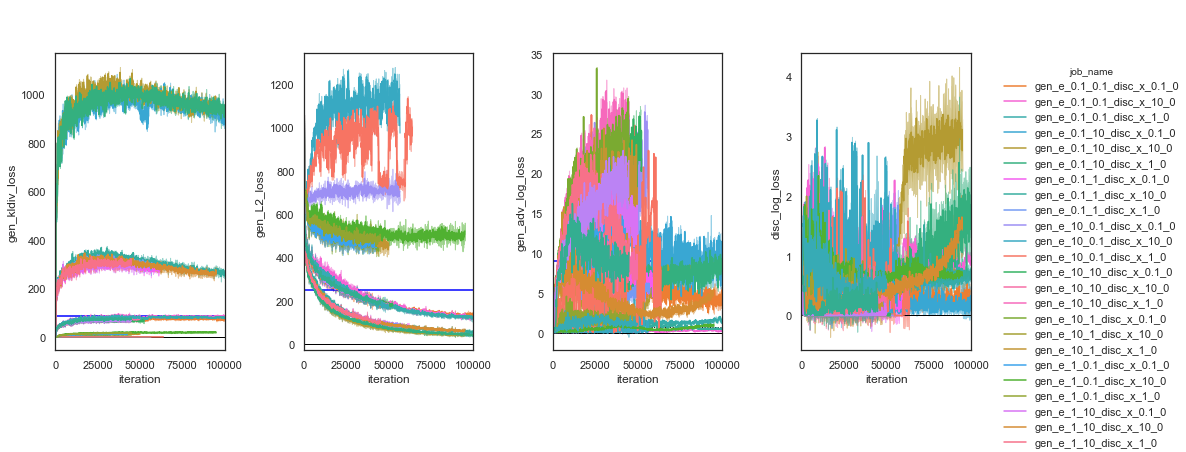

In [35]:
colors = sns.color_palette('husl', n_colors=train_df['job_name'].nunique())

np.random.seed(0)
np.random.shuffle(colors)

plot_df = train_df.copy()

x = 'iteration'
y = [
    'gen_kldiv_loss',
    'gen_L2_loss',
    'gen_adv_log_loss',
    'disc_log_loss',
]
hue = 'job_name'

fig = plot_lines('loss_weights_lines.png', plot_df, x=x, y=y, hue=hue, colors=colors,
                  n_cols=4, height=5, width=3.5, lgd_h=1.1)

baselines = [85, 250, 9, 0.2] # est. from loss_types/gen_e_disc_x_0 at iteration 40-50k

for ax, bl in zip(fig.axes, baselines):
    xlim = ax.get_xlim()
    ax.hlines(bl, xlim[0], xlim[1], color='b')
    ax.set_xlim(*xlim)


In [37]:
cols = ['iteration'] + y
plot_df.groupby('job_name').last().sort_values('gen_L2_loss', ascending=True)[cols]

,iteration,gen_kldiv_loss,gen_L2_loss,gen_adv_log_loss,disc_log_loss
job_name,,,,,
gen_e_0.1_10_disc_x_0.1_0,100000,912.993164,39.694942,8.767912,9.032341e-02
gen_e_0.1_10_disc_x_1_0,100000,958.031561,41.936477,7.945107,1.917172e+00
gen_e_0.1_10_disc_x_10_0,94900,917.079773,44.808306,8.832418,2.925346e+00
gen_e_0.1_1_disc_x_10_0,100000,252.905615,54.507976,0.415873,7.672204e-01
gen_e_1_10_disc_x_10_0,94900,265.594716,64.857908,5.607801,1.451474e+00
gen_e_0.1_1_disc_x_1_0,57200,288.412384,76.271701,5.725402,1.476952e+00
gen_e_0.1_1_disc_x_0.1_0,61900,274.691920,79.612174,4.975483,5.943620e-01
gen_e_0.1_0.1_disc_x_10_0,99900,85.332479,116.654712,0.270501,8.312594e-01
gen_e_0.1_0.1_disc_x_1_0,100000,76.427732,119.893214,1.701388,6.052795e-01


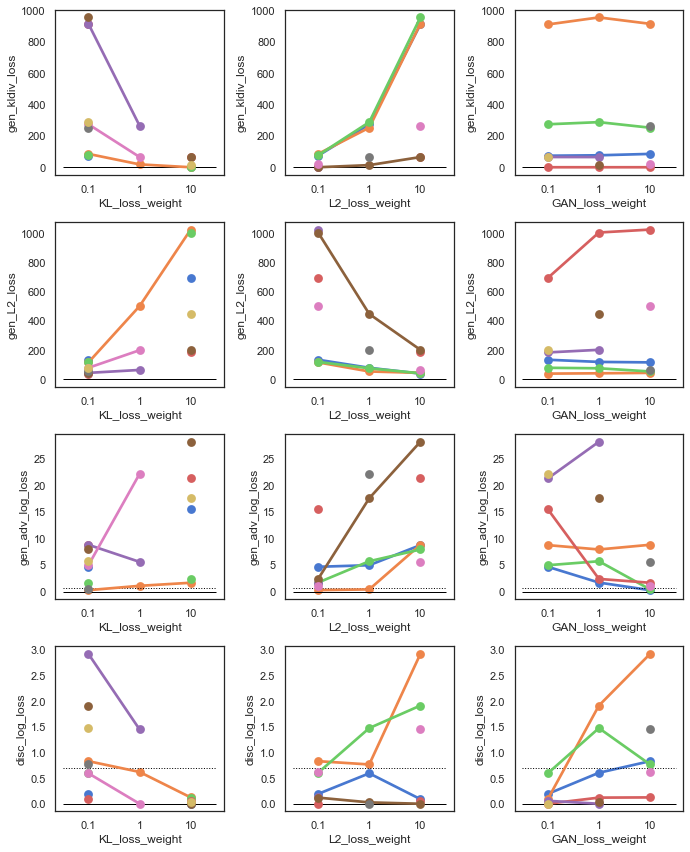

In [38]:
from results import plot_strips, add_group_column
sns.color_palette('muted')

plot2_df = plot_df.groupby('job_name').last().reset_index()
plot2_df = plot2_df[plot2_df['iteration'] >= 40000]

x = ['KL_loss_weight', 'L2_loss_weight', 'GAN_loss_weight']
y = y
hue = 'job_name'

for c1 in x:
    add_group_column(plot2_df, [c2 for c2 in x if c2 != c1])

fig = plot_strips('loss_weights_strips.png', plot2_df, x=x, y=y, grouped=True,
                  height=3, width=3.25, n_cols=3, point=True)

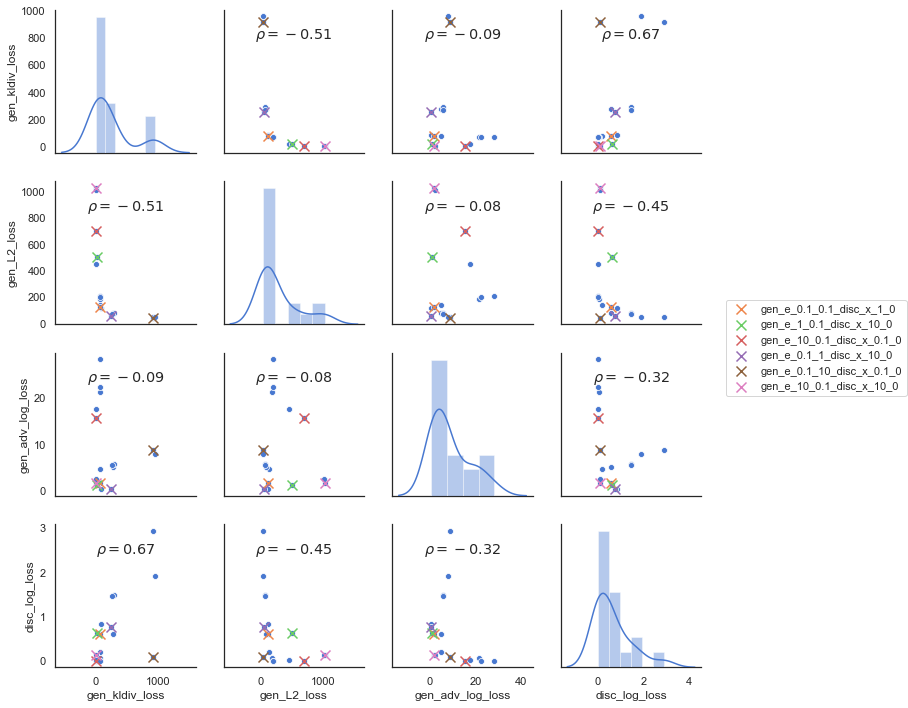

In [90]:
from results import plot_corr
from collections import defaultdict

plot3_df = plot2_df.copy()

fig = plot_corr('loss_weight_corr.png', plot3_df, x=y, y=y,
                height=2.5, width=2.5)

colors = sns.color_palette()[1:]
color_map = dict()

def joint_loss_metric(loss1, loss2):
    return (loss1 / loss1.std())**2 + (loss2 / loss2.std())**2

# create joint loss columns and assing colors to best jobs
for xi in range(len(y)):
    for yi in range(len(y)):
        if yi != xi:
            x_col = y[xi]
            y_col = y[yi]
            xy_col = ', '.join(sorted([x_col, y_col]))
            plot3_df[xy_col] = joint_loss_metric(plot3_df[x_col], plot3_df[y_col])
            best_by_xy = plot3_df.sort_values(xy_col, ascending=True)
            
            for i, row in best_by_xy.head(1).iterrows():
                job_name = row['job_name']
                if job_name not in color_map:
                    color_map[job_name] = colors[len(color_map)]

# plot best jobs by joint loss in their assigned colors
for xi in range(len(y)):
    for yi in range(len(y)):
        if yi != xi:
            x_col = y[xi]
            y_col = y[yi]
            xy_col = ', '.join(sorted([x_col, y_col]))
            best_by_xy = plot3_df.sort_values(xy_col, ascending=True)
            
            ax = fig.axes[yi*len(y) + xi]
            for job_name, color in color_map.items():
                color = color_map[job_name]
                row = plot3_df[plot3_df['job_name'] == job_name]
                x_val, y_val = row[y[xi]], row[y[yi]]
                ax.scatter(x_val, y_val, s=size, marker='x', color=color, zorder=100, label=job_name)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
print()